In [2]:
# Импортирование библиотек для иницализации основных параметров системы
from fortran_calc_tools import *

# Импортирование неодходимых библиотек
from os import path 
import time
import pandas as pd, numpy as np
from collections import namedtuple
from calc_tools import pairwise_1, pairwise_2
from scipy.linalg import logm, expm, sqrtm, eig, lu, lu_factor, lu_solve
from multiprocessing import Pool
from numpy.linalg import inv
from numpy import linalg as LA 

# Импортирование библиотек для визуализации данных !!!!!
import matplotlib.pyplot as plot
import matplotlib as mpl
import seaborn as sns
import plotly as pt
import plotly.express as px
%matplotlib inline
import plotly.graph_objects as go

In [3]:
# Задание значении характеристик материала для фаз и троса
#                         GM    OPM    S     XA   YA
Faza_A = Fazy("Фаза А", 35.336, 1.0, 150.0, 0.0, 19.0)
Faza_B = Fazy("Фаза В", 35.336, 1.0, 150.0, 6.3, 19.0)
Faza_C = Fazy("Фаза С", 35.336, 1.0, 150.0, 4.2, 25.0)
Tross = Fazy("Тросс", 17.336, 4000.0, 50.0, 2.1, 28.0)

# В данном случае у нас будет 50 гармоник от [1 до 50]
garmoniki = Garmoniki(50)

# Создание объекта для проведения расчетов
rashet = Rachety()

# Инициализация объекта для подстанции "Зеленая" и чтение файла
basepath = path.abspath('')
filepath = path.abspath(path.join(basepath, "..", path.join("data", "Данные ПС Сарепта1.xls")))
PodS_zelenaya = PodStans(filepath, volt=110, harm_num=49)

dummy_str_input = "fuzzBuzz for testing"
dummy_int_input = 404

system = System(PodS_zelenaya, garmoniki, rashet, Fazy, dummy_str_input, dummy_str_input, dummy_int_input, dummy_int_input,
     dummy_int_input, dummy_int_input, dummy_int_input)

# Установка конфигурации для выведения данных
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [4]:
# GETTING MAIN LINE CHARACTERISTICS FROM EXCEL FILE
UM, FUM, AIM, FIM, funu, fu, funi, fi, knsu, knsi, rmsu, rmsi = system.line_matrix(1)

In [5]:
# DECLARING VARIABLES

WD = np.zeros((2, 50))
PD = np.zeros((3, 700))

UM1 = np.zeros((700, UM.shape[1],UM.shape[2]))
UM2 = np.zeros((700, UM.shape[1],UM.shape[2]))
AIM1 = np.zeros((700, UM.shape[1],UM.shape[2]))
AIM2 = np.zeros((700, UM.shape[1],UM.shape[2]))
PPR1, PPR2 = np.zeros((700), dtype="complex64"), np.zeros((700), dtype="complex64")

PPP = np.zeros((1000, 50)); PPP1 = np.zeros((1000, 50));
PPP2 = np.zeros((1000, 50)); PPP3 = np.zeros((1000, 50));
PPP4 = np.zeros((1000, 50)); PPP5 = np.zeros((1000, 50));
PPP6 = np.zeros((1000, 50)); PPP7 = np.zeros((1000, 50));
PPP8 = np.zeros((1000, 50));

# !!!!!!!!!!!!!!!!! CordN = 8 was in original here 
cordN = 8
UK1 = np.array([complex(0, 0) for _ in range(cordN)], dtype="complex64")
AIK1 = np.array([complex(0, 0) for _ in range(cordN)])

UK10 = complex(0, 0); UK11 = complex(0, 0); UK12 = complex(0, 0);
AIK10 = complex(0, 0); AIK11 = complex(0, 0); AIK12 = complex(0, 0);
AL = complex(-0.5, 0.866025);

PP1 = 0.0
PP2 = 0.0
RZ = 35.3

In [6]:
# Implementing RASCHET fortran's subroutine in python
def RASCHET(NN, LL, PR):
# LL is in range [0-559] NN [0-49]

#     print(NN, LL)
    global UK1, AIK1, PPP,PP1,PP2,PPP1,PPP2,PPP3,PPP4,PPP5,PPP6,PPP7,PPP8, MM,M,M1,MT,M10,M20,K1,K2,K3,N1,N2,N3,MPR,MTR,MMT
    
    
    XA, YA, OMP, GM, S = Fazy.construc_matrices()
    R0, R, UXM, HI, R11, DET2, DET4 = np.zeros((M)), np.zeros((M)), np.zeros((M)), np.zeros((M)), np.zeros((M)), np.zeros((M)), np.zeros((M))
    EVU, B, UX, AIX, SM, EVI, DET1, DET3, BB, AIXM, AA = np.zeros((M)), np.zeros((M), dtype="complex64"), np.zeros((M), dtype="complex64"), np.zeros((M), dtype="complex64"), np.zeros((M), dtype="complex64"), np.zeros((M)), np.zeros((M), dtype="complex64"), np.zeros((M), dtype="complex64"), np.zeros((M)), np.zeros((M)), np.zeros((M)),
    B1, B4, B5 = np.zeros((M20), dtype="complex64"), np.zeros((M20)), np.zeros((M20), dtype="complex64")
    B6, B10, B7 = np.zeros((M10)), np.zeros((M10), dtype="complex64"), np.zeros((M10)) 
    
    DET10, DET20, SS, SS1, EX1,  = [], [], [], [], []
    
    HC1, HC2, HC3, HC4, F10, XL, XL1, G, D, HC, UXM = np.zeros((M, M)), np.zeros((M, M)), np.zeros((M, M)), np.zeros((M, M)), np.zeros((M, M)), np.zeros((M, M)), np.zeros((M, M)), np.zeros((M, M)), np.zeros((M, M)), np.zeros((M, M)), np.zeros((M, M)) 
    Z, Y, AU, E,  AAI, F, F1 = np.zeros((M, M), dtype="complex64"), np.zeros((M, M), dtype="complex64"), np.zeros((M, M)), np.zeros((M, M), dtype="complex64"), np.zeros((M, M)), np.zeros((M, M), dtype="complex64"), np.zeros((M, M), dtype="complex64")
    F2, D1, D2, D3, LU, LI = np.zeros((M, M)), np.zeros((M, M)), np.zeros((M, M)), np.zeros((M, M)), np.zeros((M, M), dtype="complex64"), np.zeros((M, M), dtype="complex64")
    LU1, LI1, LU2, LU3, LI2, LI3 = np.zeros((M, M), dtype="complex64"), np.zeros((M, M), dtype="complex64"), np.zeros((M, M), dtype="complex64"), np.zeros((M, M), dtype="complex64"), np.zeros((M, M), dtype="complex64"), np.zeros((M, M), dtype="complex64")
    F3, F4, F5, F6, F7 = np.zeros((M, M)), np.zeros((M, M)), np.zeros((M, M)), np.zeros((M, M)), np.zeros((M, M))
    HH13, HH14, HH21, HH22, HH23 = np.zeros((M, M), dtype="complex64"), np.zeros((M, M), dtype="complex64"), np.zeros((M, M), dtype="complex64"), np.zeros((M, M), dtype="complex64"), np.zeros((M, M), dtype="complex64")
    HH31, HH32, HH33, HH34, HH24 = np.zeros((M, M), dtype="complex64"), np.zeros((M, M), dtype="complex64"), np.zeros((M, M), dtype="complex64"), np.zeros((M, M), dtype="complex64"), np.zeros((M, M), dtype="complex64")
    HH41, HH42, HH43, HH44, HH = np.zeros((M, M), dtype="complex64"), np.zeros((M, M), dtype="complex64"), np.zeros((M, M), dtype="complex64"), np.zeros((M, M), dtype="complex64"), np.zeros((M10, M10))
    CC, DD, HH11, HH12 = np.zeros((M, M)), np.zeros((M, M)), np.zeros((M, M), dtype="complex64"), np.zeros((M, M), dtype="complex64")
    A1, A2 = np.zeros((M1, M1), dtype="complex64"), np.zeros((M1, M1), dtype="complex64")
    
    AG, GG = np.zeros((M1, M, M), dtype=type), np.zeros((M20, M20), dtype="complex64")
    GG1, GG2, GG3, GG4, GG5 = np.zeros((M20, M20), dtype="complex64"), np.zeros((M20, M20), dtype="complex64"), np.zeros((M10, M20), dtype="complex64"), np.zeros((M10, M10), dtype="complex64"), np.zeros((M10, M10), dtype="complex64")
    IPVT1, IH = np.zeros((M1)), np.array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0])
    
    # REDUCING DIMENSIONS PYTHON SPECIFIC ONLY !
    UK1 = UK1[:4]
    AIK1 = AIK1[:4]
    
    if PR == 1:
        PP1 = 0
    if PR == 2:
        PP2 = 0
#     PPP[NN, LL] = 0
#     PPP1[NN, LL] = 0
#     PPP2[NN, LL] = 0
#     PPP3[NN, LL] = 0
#     PPP4[NN, LL] = 0
#     PPP5[NN, LL] = 0
#     PPP6[NN, LL] = 0
#     PPP7[NN, LL] = 0
#     PPP8[NN, LL] = 0
    
    MMT = MM / MT
    W = float(LL+1)
    EX1 = complex(2.71828, 0)
    
    # WRITING INTO UNIT 5. LINE MAIN CHARACTERISTIC
    
    for i in range(M):
        R[i]=squareroot(S[i]/PI)/1000.
        HI[i]=R[i]/(2.)*squareroot(2*PI*W*50*4*PI*OMP[i]*GM[i]/20)
        R0[i]=1000/(GM[i]*S[i])
        if HI[i] < 1:
            R11[i]=R0[i]*(1+HI[i]**4/3)
        if HI[i] > 1: 
            R11[i]=R0[i]*(HI[i]+0.25+3./(64.*HI[i]))
        if i+1 == M:
            pass
            # WRITE R11's values INTO THE FILE "R11"

    
    # 845 - 12
    for i in range(M10):
        for j in range(M10):
            HH[i,j] = 0 

    # 12 - 161
    for i in range(M):
        for j in range(M):
            if i == j:
                D[i,i] = R[i]
            if i != j:
                D[i,j]=squareroot((XA[i]-XA[j])**2+(YA[i]-YA[j])**2)
            HC[i,j]=squareroot((XA[i]-XA[j])**2+(YA[i]+YA[j])**2)
            E[i,j]=complex(0.0, 0.0)
            E[i,i]=complex(1.0, 0.0)

    # 161 - 740
    for i in range(M):
        for j in range(M):
            XL1[i,j]=(0.145*logarithm10(1000/D[i,j]))/(100*PI)
    
    # 740 - 743
    for i in range(M):
        for j in range(M):
            HC1[i,j]=41.4*10**6*logarithm10(HC[i,j]/D[i,j])
    
    # 743 - 744
    HC1 = HC1.astype('float64')
    HC3 = DLINRG(HC1)
    F10 = DMRRRR(HC1,HC3)
    
    for i in range(M):
        for j in range(M):
            HC2[i,j]=HC3[i,j]*2.*PI*50
    
    # 744 - 847
    for i in range(M):
        for j in range(M):
            XL[i,j]=XL1[i,j]*W*2*50*PI
            HC4[i,j]=HC2[i,j]*W
            R10=0.0
            if i == j:
                Z[i,j]=complex(R11[i],XL[i,j]) 
            if i != j:
                Z[i,j]=complex(R10,XL[i,j])
            if i == j:
                G[i,j]=0.00000004*YA[i]/YA[i] 
            if i != j:
                G[i,j]=-0.00000004*YA[0]/D[i,j] 
            G[i,j]=0.
            Y[i,j]=complex(G[i,j],HC4[i,j])

       
    # 847 - the end of subroutine        
    for III in range(MT): # <----- main loop # 1300
        
        if M != 3: # GOTO 767            
            if (M != 4): # GOTO 768                
                if (M != 6): # GOTO 769
                    if (M != 7): # GOTO 770
                        if (M != 8): # GOTO 771
                            pass

                        else:
                            # 770 - 766
                            for i in range(3):
                                B5[i]=UK1[i]
                                B5[i+3]=UK1[i]
                                B5[MPR+1-1]=complex(0.,0.)
                                B5[MPR+2-1]=complex(0.,0.)
                                B5[i+M]=AIK1[i]
                                B5[i+M+3]=AIK1[i]
                                B5[2*M-1-1]=complex(0.,0.)
                                B5[2*M-1]=complex(0.,0.)
                                B5[i+2*M]=complex(0.,0.)
                                B5[i+2*M+3]=complex(0.,0.)
                                B5[3*M-1-1]=complex(0.,0.)
                                B5[3*M-1]=complex(0.,0.)
                                B5[i+3*M]=complex(0.,0.)
                                B5[i+3*M+3]=complex(0.,0.)
                                B5[4*M-1-1]=complex(0.,0.)
                                B5[4*M-1]=complex(0.,0.)
                          
                    else:
                        # 769 - 765
                        for i in range(3):
                            B5[i]=UK1[i]
                            B5[i+3]=UK1[i] 
                            B5[M-1]=complex(0.,0.) 
                            B5[i+M]=AIK1[i]
                            B5[i+M+3]=AIK1[i] 
                            B5[2*M-1]=complex(0.,0.)
                            B5[i+2*M]=complex(0.,0.)
                            B5[i+2*M+3]=complex(0.,0.)
                            B5[3*M-1]=complex(0.,0.)
                            B5[i+3*M]=complex(0.,0.)
                            B5[i+3*M+3]=complex(0.,0.)
                            B5[4*M-1]=complex(0.,0.)
                      

                else:
                    # 768 - 764
                    for i in range(3):
                        B5[i]=UK1[i]
                        B5[i+3]=UK1[i]
                        B5[i+M]=AIK1[i]
                        B5[i+M+3]=AIK1[i]
                        B5[i+2*M]=complex(0.,0.)
                        B5[i+2*M+3]=complex(0.,0.)
                        B5[i+3*M]=complex(0.,0.)
                        B5[i+3*M+3]=complex(0.,0.)

            else:
#               CONTSTATNLY RUNS THIS BRANCH
                # 767 - 762
                for i in range(3):
                    B5[i]=UK1[i]
                    B5[M-1]=complex(0.,0.)
                    B5[i+M]=AIK1[i]
                    B5[2*M-1]=complex(0.,0.)
                    B5[i+2*M]=complex(0.,0.)
                    B5[3*M-1]=complex(0.,0.)
                    B5[i+3*M]=complex(0.,0.)
                    B5[4*M-1]=complex(0.,0.)
                
        else:
            # 847 - 761
            for i in range(3):
                B5[i]=UK1[i]
                B5[i+3]=AIK1[i]
                B5[i+6]=complex(0.,0.)
                B5[i+9]=complex(0.,0.)
            
# &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&& DEBUGGING &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&

#         debugging_tool("B5", B5) #           !!! B5 IS STILL NOT OK !!! VERY FITST ITEM OF THE ARRAY 
        AU = DMCRCR(Z,Y)                  # AU is OK !
        SS1=squareroot(AU[0,0])                  # SS1 is OK !
        EVU = DEVLCG(AU, True)                  # EVU is OK !
        
        # IMPORTANT POINT
        for j in range(M):
            for i in range(M):
                F[i,j]=EVU[i]**j # (j-1) was in the first case
                F1[i,j]=F[i,j]
                
        for i in range(M1):
            for j in range(M1):
                A1[i,j]=F[i,j]
        
        # After 201th CONTINUE
        A2, A2a = DLFTCG(A1)                              # A1 and A2 are OK !
        DET10 = DLFDCG(A2a); DET20 = 0 # parameters DET10,DET20 were in function call
        SS = DET10*(10**DET20)
        
        for j in range(M1):

            for ii in range(M1):
                for jj in range(M1):
                    F[ii,jj]=F1[ii,jj]
        
            for i in range(M1):
                F[i,j]=EVU[i]**0.5
            
            for ii in range(M1):
                for jj in range(M1):
                    A1[ii,jj]=F[ii,jj]
            
            # After 202th CONTINUE
            A2, A2a = DLFTCG(A1)
            DET1[j] = DLFDCG(A2a); DET2[j] = 0 # parameters DET1(J), DET2(J) were in function call
            
        F2 = DMCRCR(AU,AU)
        F3 = DMCRCR(F2,AU)
        F4 = DMCRCR(F3,AU)
        F5 = DMCRCR(F4,AU)
        F6 = DMCRCR(F5,AU)
        F7 = DMCRCR(F6,AU)
        
        for i in range(M1):
            for ii in range(M):
                for jj in range(M):

                    if i == 0:
                        AG[0,ii,jj]=E[ii,jj]
                    if i == 1:
                        AG[1,ii,jj]=AU[ii,jj]
                    if i == 2:
                        AG[2,ii,jj]=F2[ii,jj]
                    if i == 3:
                        AG[3,ii,jj]=F3[ii,jj]
                    if i == 4:
                        AG[4,ii,jj]=F4[ii,jj]
                    if i == 5:
                        AG[5,ii,jj]=F5[ii,jj]
                    if i == 6:
                        AG[6,ii,jj]=F6[ii,jj]
                    if i == 7:
                        AG[7,ii,jj]=F7[ii,jj]
        
        for ii in range(M):
            for jj in range(M):
                LU[ii,jj]=0.

        for i in range(M1):
            DET3[i]=DET1[i]/DET10
            DET4[i]=DET2[i]-DET20
            for ii in range(M):
                for jj in range(M):
                    LU[ii,jj]=LU[ii,jj]+AG[i,ii,jj]*DET3[i]*(10**DET4[i])
        
        F3 = DMCRCR(LU,LU)
        AAI = DMCRCR(Y,Z)
        EVI = DEVLCG(AAI)
        
        for j in range(M):
            for i in range(M):
                F[i,j] = EVI[i]**j # j-1
                F1[i,j] = F[i,j]
        
        for i in range(M1):
            for j in range(M1):
                A1[i,j]=F[i,j]
        
        A2, A2a = DLFTCG(A1)
        DET10 = DLFDCG(A2a); DET20 = 0 # parameters DET10,DET20 were in function call
        
        for j in range(M1):
            for ii in range(M1):
                for jj in range(M1):
                    F[ii,jj]=F1[ii,jj]

            for i in range(M1):
                F[i,j]=EVI[i]**0.5
            for ii in range(M1):
                for jj in range(M1):
                    A1[ii,jj]=F[ii,jj]
            
            A2, A2a = DLFTCG(A1)
            DET1[j] = DLFDCG(A2a); DET2[j] = 0 # parameters DET1(J),DET2(J) were in function call
            
        F2 = DMCRCR(AAI,AAI)
        F3 = DMCRCR(F2,AAI,)
        F4 = DMCRCR(F3,AAI)
        F5 = DMCRCR(F4,AAI)
        F6 = DMCRCR(F5,AAI)
        F7 = DMCRCR(F6,AAI)

        for i in range(M1):
            for ii in range(M):
                for jj in range(M):

                    if i == 0:
                        AG[0,ii,jj]=E[ii,jj]
                    if i == 1:
                        AG[1,ii,jj]=AAI[ii,jj]
                    if i == 2:
                        AG[2,ii,jj]=F2[ii,jj]
                    if i == 3:
                        AG[3,ii,jj]=F3[ii,jj]
                    if i == 4:
                        AG[4,ii,jj]=F4[ii,jj]
                    if i == 5:
                        AG[5,ii,jj]=F5[ii,jj]
                    if i == 6:
                        AG[6,ii,jj]=F6[ii,jj]
                    if i == 7:
                        AG[7,ii,jj]=F7[ii,jj]

        for ii in range(M):
            for jj in range(M):
                LI[ii,jj]=0.
        
        for i in range(M1):
            for ii in range(M):
                for jj in range(M):
                    LI[ii,jj]=LI[ii,jj]+(DET1[i]*(10**DET2[i])*AG[i,ii,jj])/(DET10*(10**DET20))
        
        F3 = DMCRCR(LI,LI)
        LM=MMT
        
        for n, _ in enumerate(range(2), start=1):

            if n == 1:
                SA=-1.
            if n == 2:
                SA=1.

            for ii in range(M):
                for jj in range(M):
                    LU1[ii,jj]=SA*MMT*LU[ii,jj]


            EVU = DEVLCG(LU1)
            for i in range(M):
                for j in range(M):
                    F[i,j]=EVU[i]**j # (j-1) here was an expression (j-1)


            for ii in range(M):
                for jj in range(M):
                    F1[ii,jj]=F[ii,jj]


            for ii in range(M1):
                for jj in range(M1):
                    A1[ii,jj]=F[ii,jj]
            
#             debugging_tool("A1", A1)
            A2, A2a = DLFTCG(A1) #         !!! HERE APPEARS INFINITY AND TOO LARGE NUMBERS!!!
            DET10 = DLFDCG(A2a); DET20 = 0 # DET10 and DET20 were the arguments of this function
            
            for j in range(M):
                for ii in range(M):
                    for jj in range(M):
                        F[ii,jj]=F1[ii,jj]


                for i in range(M):
                    F[i,j]=EX1**EVU[i]


                for ii in range(M1):
                    for jj in range(M1):
                        A1[ii,jj]=F[ii,jj]

#                 debugging_tool("A1", A1)
                A2, A2a = DLFTCG(A1) #         !!! HERE APPEARS INFINITY AND TOO LARGE NUMBERS!!!
                DET1[j] = DLFDCG(A2a); DET2[j] = 0
            
            F2 = DMCRCR(LU1,LU1)
            F3 = DMCRCR(F2,LU1)
            F4 = DMCRCR(F3,LU1)
            F5 = DMCRCR(F4,LU1)
            F6 = DMCRCR(F5,LU1)
            F7 = DMCRCR(F6,LU1)

            for i in range(M1):
                for ii in range(M):
                    for jj in range(M):

                        if i == 0:
                            AG[0,ii,jj]=E[ii,jj]
                        if i == 1:
                            AG[1,ii,jj]=LU1[ii,jj]
                        if i == 2:
                            AG[2,ii,jj]=F2[ii,jj]
                        if i == 3:
                            AG[3,ii,jj]=F3[ii,jj]
                        if i == 4:
                            AG[4,ii,jj]=F4[ii,jj]
                        if i == 5:
                            AG[5,ii,jj]=F5[ii,jj]
                        if i == 6:
                            AG[6,ii,jj]=F6[ii,jj]
                        if i == 7:
                            AG[7,ii,jj]=F7[ii,jj]

            for ii in range(M):
                for jj in range(M):
                    LU2[ii,jj]=0.

            for i in range(M1):
                for ii in range(M):
                    for jj in range(M):
                        LU2[ii,jj]=LU2[ii,jj]+(DET1[i]*(10**DET2[i])*AG[i,ii,jj])/(DET10*(10**DET20))

            if n == 2:
                F2 = DMCRCR(LU3,LU2)
                continue
            else:
                for ii in range(M):
                    for jj in range(M):
                        LU3[ii,jj]=LU2[ii,jj]

        for n in range(2):
            if n == 0:
                SA=-1
            if n == 1:
                SA=1

            for ii in range(M):
                for jj in range(M):
                    LI1[ii,jj]=SA*MMT*LI[ii,jj]

            EVI = DEVLCG(LI1)

            for i in range(M):
                for j in range(M):
                    F[i,j]=EVI[i]**j # J-1 in original

            for ii in range(M):
                for jj in range(M):
                    F1[ii,jj]=F[ii,jj]

            for ii in range(M1):
                for jj in range(M1):
                    A1[ii,jj]=F[ii,jj]

            A2, A2a = DLFTCG(A1)
            DET10 = DLFDCG(A2a); DET20 = 0
            
            for j in range(M):
                for ii in range(M):
                    for jj in range(M):
                        F[ii,jj]=F1[ii,jj]

                for i in range(M):
                    F[i,j]=EX1**EVI[i]

                for ii in range(M1):
                    for jj in range(M1):
                        A1[ii,jj]=F[ii,jj]

                A2, A2a = DLFTCG(A1)
                DET1[j] = DLFDCG(A2a); DET2[j] = 0


            F2 = DMCRCR(LI1,LI1)
            F3 = DMCRCR(F2,LI1)
            F4 = DMCRCR(F3,LI1)
            F5 = DMCRCR(F4,LI1)
            F6 = DMCRCR(F5,LI1)
            F7 = DMCRCR(F6,LI1)
            
            for i in range(M1):
                for ii in range(M):
                    for jj in range(M):
                        if i == 0:
                            AG[0,ii,jj]=E[ii,jj]
                        if i == 1:
                            AG[1,ii,jj]=LI1[ii,jj]
                        if i == 2:
                            AG[2,ii,jj]=F2[ii,jj]
                        if i == 3:
                            AG[3,ii,jj]=F3[ii,jj]
                        if i == 4:
                            AG[4,ii,jj]=F4[ii,jj]
                        if i == 5:
                            AG[5,ii,jj]=F5[ii,jj]
                        if i == 6:
                            AG[6,ii,jj]=F6[ii,jj]
                        if i == 7:
                            AG[7,ii,jj]=F7[ii,jj]

            for ii in range(M):
                for jj in range(M):
                    LI2[ii,jj]=0

            for i in range(M1):
                for ii in range(M):
                    for jj in range(M):
                        LI2[ii,jj]=LI2[ii,jj]+(DET1[i]*(10**DET2[i])*AG[i,ii,jj])/(DET10*(10**DET20))
            
            if n == 2:
                continue
            else:
                for ii in range(M):
                    for jj in range(M):
                        LI3[ii,jj]=LI2[ii,jj]


        F2 = DMCRCR(LI3,LI2)
        
        for i in range(M20):
            for j in range(M20):
                GG[i,j]=0.
                GG1[i,j]=0.
                GG2[i,j]=0.

        for i in range(M):
            GG[i,i]=1.
            GG[i,i+M]=1.
            GG[i+M,i+2*M]=1.
            GG[i+M,i+3*M]=1.
            GG1[i,i]=1.
            GG1[i,i+M]=1.
            GG1[i+M,i+2*M]=1.
            GG1[i+M,i+3*M]=1.
        
        for i in range(M):
            for j in range(M):
                GG[i+2*M,j]=-LU[i,j]
                GG[i+2*M,j+M]=LU[i,j]
                GG[i+3*M,j+2*M]=-1*LI[i,j]
                GG[i+3*M,j+3*M]=+LI[i,j]

                GG1[i+2*M,j]=LU3[i,j]
                GG1[i+2*M,j+M]=LU2[i,j]
                GG1[i+3*M,j+2*M]=LI3[i,j]
                GG1[i+3*M,j+3*M]=LI2[i,j]

        GG2 = DLINCG(M20,GG1) # Look for M20

        for i in range(M):
            for j in range(M):
                HH11[i,j]=GG2[i,j]
                HH12[i,j]=GG2[i,j+M]
                HH13[i,j]=GG2[i,j+2*M]
                HH14[i,j]=GG2[i,j+3*M]
                HH21[i,j]=GG2[i+M,j]
                HH22[i,j]=GG2[i+M,j+M]
                HH23[i,j]=GG2[i+M,j+2*M]
                HH24[i,j]=GG2[i+M,j+3*M]
                HH31[i,j]=GG2[i+2*M,j]
                HH32[i,j]=GG2[i+2*M,j+M]
                HH33[i,j]=GG2[i+2*M,j+2*M]
                HH34[i,j]=GG2[i+2*M,j+3*M]
                HH41[i,j]=GG2[i+3*M,j]
                HH42[i,j]=GG2[i+3*M,j+M]
                HH43[i,j]=GG2[i+3*M,j+2*M]
                HH44[i,j]=GG2[i+3*M,j+3*M]
        
        F = DMCRCR(LU3,HH11)
        HH11 = DMCRCR(LU,F)
        F = DMCRCR(LU2,HH21)
        HH21 = DMCRCR(LU,F)
        F = DMCRCR(LU3,HH13)
        HH13 = DMCRCR(LU,F)
        F = DMCRCR(LU2,HH23)
        HH23 = DMCRCR(LU,F)
        F = DMCRCR(LI3,HH32)
        HH32 = DMCRCR(LI,F)
        F = DMCRCR(LI2,HH42)
        HH42 = DMCRCR(LI,F)
        F = DMCRCR(LI3,HH34)
        HH34 = DMCRCR(LI,F)
        F = DMCRCR(LI2,HH44)
        HH44 = DMCRCR(LI,F)
        
        for i in range(M10):
            for j in range(M20):
                GG3[i,j]=0.0

        for i in range(M):
            for j in range(M):
                GG3[i,j]=-1*HH11[i,j]+HH21[i,j]
                GG3[i,j+2*M]=-1*HH13[i,j]+HH23[i,j]
                GG3[i,j+3*M]=-1*Z[i,j]
                GG3[i+M,j+M]=-1*HH32[i,j]+HH42[i,j]
                GG3[i+M,j+2*M]=-1*Y[i,j]
                GG3[i+M,j+3*M]=-1*HH34[i,j]+HH44[i,j]
        
        K1=0
        K0=0

        for j in range(M20):

            if IH[j] == 1:
                K1=K1+1
            if IH[j] == 0:
                if IH[j] == 0:
                    K0=K0+1
                if IH[j] == 1:
                    continue
                   
                for i in range(M10):
                    GG5[i,K0-1]=GG3[i,j]

            else:
                for i in range(M10):
                    GG4[i,K1-1]=-1*GG3[i,j] # Original was -GG3[i,j]
                    B10[K1-1]=B5[j]


        B6 = DMUCRV(GG4,B10)     
        B7 = DLSLCG(GG5,B6)
        
        K1=0

        for j in range(M20):
            if IH[j] == 0:
                K1=K1+1
            if IH[j] == 1:
                continue

            B5[j]=B7[K1-1]

        for i in range(M):
            UK1[i]=B5[i]
            AIK1[i]=B5[i+M]
        
        AA = DMUCRV(Z,AIK1)
        BB = DMUCRV(Y,UK1)
        CC = DMCRCR(LI,LI3)
        DD = DMCRCR(LI,LI2)
        
        for i in range(M):
            B1[i]=UK1[i]
            B1[i+M]=AIK1[i]
            B1[i+2*M]=AA[i]
            B1[i+3*M]=BB[i]
        
        B4 = DLSLCG(GG,B1)
        
        for i in range(M):
            AA[i]=0.
            B[i]=0.
            B[i]=B4[i]

        AA = DMUCRV(LU3,B)

        for i in range(M):
            BB[i]=0.
            B[i]=0.
            B[i]=B4[i+M]

        BB = DMUCRV(LU2,B)

        for i in range(M):
            UX[i]=AA[i]+BB[i]
            if LM == MMT:
                UK1[i]=UX[i]
            UXM[i]=squareroot(UX[i].real**2+UX[i].imag**2)

        for i in range(M):
            AA[i]=0.
            B[i]=0.
            B[i]=B4[i+2*M]
        
        AA = DMUCRV(LI3,B)  
        
        for i in range(M):
            BB[i]=0.
            B[i]=0.
            B[i]=B4[i+3*M]
        
        BB = DMUCRV(LI2,B)  
        
        for i in range(M):
#             with open("AIXM.txt", "a") as aixm, open("R11.txt", "a") as r11, open("AIX.txt", "a") as aix:       
            AIX[i]=AA[i]+BB[i]
            if LM == MMT:
                AIK1[i]=AIX[i]
#                 aix.write(str(AIX[i])+"\n")
            AIXM[i]=squareroot(AIX[i].real**2+AIX[i].imag**2)
#                 debugging_tool("AIXM", AIXM[i])
#                 aixm.write(str(AIXM[i])+"\n")
#                 r11.write(str(R11[i])+"\n")
            if i == 0 and LL == 0 and PR == 2:
                PPP1[NN,LL]=PPP1[NN,LL]+AIXM[0]**2/2*R11[0]
            if i == 0 and LL > 0:
                PPP1[NN,LL]=PPP1[NN,LL]+AIXM[0]**2/2*R11[0]
            if i == 1 and LL == 0 and PR == 2:
                PPP2[NN,LL]=PPP2[NN,LL]+AIXM[1]**2/2*R11[1]
            if i == 1 and LL > 0:
                PPP2[NN,LL]=PPP2[NN,LL]+AIXM[1]**2/2*R11[1]
            if i == 2 and LL == 0 and PR == 2:
                PPP3[NN,LL]=PPP3[NN,LL]+AIXM[2]**2/2*R11[2]
            if i == 2 and LL > 0:
                PPP3[NN,LL]=PPP3[NN,LL]+AIXM[2]**2/2*R11[2]
            if i == 3 and LL == 0 and PR == 2:
                PPP4[NN,LL]=PPP4[NN,LL]+AIXM[3]**2/2*R11[3]
            if i == 3 and LL > 0:
                PPP4[NN,LL]=PPP4[NN,LL]+AIXM[3]**2/2*R11[3]
            if i == 4 and LL == 0 and PR == 2:
                PPP5[NN,LL]=PPP5[NN,LL]+AIXM[4]**2/2*R11[4]
            if i == 4 and LL > 0:
                PPP5[NN,LL]=PPP5[NN,LL]+AIXM[4]**2/2*R11[4]
            if i == 5 and LL == 0 and PR == 2:
                PPP6[NN,LL]=PPP6[NN,LL]+AIXM[5]**2/2*R11[5]
            if i == 5 and LL > 0:
                PPP6[NN,LL]=PPP6[NN,LL]+AIXM[5]**2/2*R11[5]
            if i == 6 and LL == 0 and PR == 2:
                PPP7[NN,LL]=PPP7[NN,LL]+AIXM[6]**2/2*R11[6]
            if i == 6 and LL > 0:
                PPP7[NN,LL]=PPP7[NN,LL]+AIXM[6]**2/2*R11[6]
            if i == 7 and LL == 0 and PR == 2:
                PPP8[NN,LL]=PPP8[NN,LL]+AIXM[7]**2/2*R11[7]
            if i == 7 and LL > 0:
                PPP8[NN,LL]=PPP8[NN,LL]+AIXM[7]**2/2*R11[7]

            if LL == 0 and PR == 2:
                PPP[NN,LL]=PPP[NN,LL]+AIXM[i]**2/2*R11[i]
            if LL > 0:
                PPP[NN,LL]=PPP[NN,LL]+AIXM[i]**2/2*R11[i]

            if LL == 0 and PR == 1:
                PP1=PP1+AIXM[i]**2/2*R11[i]
            if LL == 0 and PR == 2:
                PP2=PP2+AIXM[i]**2/2*R11[i]
            SM[i]=UX[i]*np.conj(AIX[i])/2

#             print(PPP1[NN, LL])

    # Writing UXM and AIXM values into 10th and 11th modules    

In [7]:
# !!!  470th loop stands for 1th or one prisoed of podstanst  !!!
PI = 3.14159265358979
# 11 - 13
for i in range(560+1):
    for p in range(3):
        UM[i,0,p] = funu[i,p]*1.414214 # 1.414214 
        FUM[i,0,p]=fu[i,p]*PI/180 
        UM1[i,0,p]=UM[i,0,p]*cosine(FUM[i,0,p]) 
        UM2[i,0,p]=UM[i,0,p]*sine(FUM[i,0,p])     
        
# 13 - 14
for i in range(560+1):
    for p in range(3):
        for k in range(50-1):
            UM[i,k+1,p]=UM[i,k+1,p]*UM[i,0,p]/100.
            FUM[i,k+1,p]=FUM[i,k+1,p]*PI/180.
            UM1[i,k+1,p]=UM[i,k+1,p]*cosine(FUM[i,k+1,p])
            UM2[i,k+1,p]=UM[i,k+1,p]*sine(FUM[i,k+1,p])

# 14 - 16
for i in range(560+1):
    for p in range(3):
        AIM[i,0,p]=funi[i,p]*1.414214
        FIM[i,0,p]=fi[i,p]*PI/180
        AIM1[i,0,p]=AIM[i,0,p]*cosine(FIM[i,0,p])
        AIM2[i,0,p]=AIM[i,0,p]*sine(FIM[i,0,p])
        
# 16 - 117
for i in range(560+1):
    for p in range(3):
        for k in range(50-1):
            AIM[i,k+1,p]=AIM[i,k+1,p]*AIM[i,0,p]/100
            FIM[i,k+1,p]=FIM[i,k+1,p]*PI/180
            AIM1[i,k+1,p]=AIM[i,k+1,p]*cosine(FIM[i,k+1,p])
            AIM2[i,k+1,p]=AIM[i,k+1,p]*sine(FIM[i,k+1,p])

In [8]:
# 117 - 1700 - 1500

print("!!! Started !!!")
print()

MM, MPR, MTR, DT, MT = 5, 3, 1, 2.5, 5 #         <---- INPUT FROM THE USER
M = MPR + MTR     # thus is 4
MMT = MM / MT    # is 1

if M <= 6:
    M1 = M # this is 4
if M > 6:
    M1 = 6

M10 = 2 * M # is 8
M20 = 4 * M # is 16

k = LoopI(0, 49) # INNER LOOP
n = LoopI(0, 560) # OUTER LOOP
PR = LoopI(1, 2)
counter = 1

start = time.time()
# with open("debug.txt", "a") as file:
while True:

    if n.the_end:
        break

    # print("START: ", n.get_current_index(), k.get_current_index())

    K = k.get_current_index(); N = n.get_current_index();
    # print(counter); counter+=1
#     file.write()
    UK1[0] = complex(UM1[N,K,0], UM2[N,K,0])
    UK1[1] = complex(UM1[N,K,1], UM2[N,K,1])
    UK1[2] = complex(UM1[N,K,2], UM2[N,K,2])
    UK1[3] = complex(0, 0)
    AIK1[0] = complex(AIM1[N,K,0], AIM2[N,K,0])
    AIK1[1] = complex(AIM1[N,K,1], AIM2[N,K,1])
    AIK1[2] = complex(AIM1[N,K,2], AIM2[N,K,2])
    AIK1[3] = complex(0, 0)


    if not (k.get_current_index() > 0):
        if not (k.get_current_index() == 0 and PR.get_current_index() == 2):
            # print(counter); counter+=1
#             file.write()
            UK10=(UK1[0]+UK1[1]+UK1[2])/3
            UK11=(UK1[0]+UK1[1]*AL+UK1[2]*AL**2)/3
            
#             debugging_tool("UK1[1]", UK1[1])
#             debugging_tool("UK1[1]*AL", (UK1[1])*AL)
            
            UK12=(UK1[0]+UK1[1]*AL**2+UK1[2]*AL)/3
            SKU2=squareroot(UK12.real**2+UK12.imag**2)/squareroot(UK11.real**2+UK11.imag**2)*100
            SKU0=squareroot(UK10.real**2+UK10.imag**2)/squareroot(UK11.real**2+UK11.imag**2)*100
            UK1[0]=UK11
            UK1[1]=UK11*AL**2
            UK1[2]=UK11*AL
            AIK10=(AIK1[0]+AIK1[1]+AIK1[2])/3
            AIK11=(AIK1[0]+AIK1[1]*AL+AIK1[2]*AL**2)/3
            AIK12=(AIK1[0]+AIK1[1]*AL**2+AIK1[2]*AL)/3
            SKI2=squareroot(AIK12.real**2+AIK12.imag**2)/squareroot(AIK11.real**2+AIK11.imag**2)*100
            SKI0=squareroot(AIK10.real**2+AIK10.imag**2)/squareroot(AIK11.real**2+AIK11.imag**2)*100
            AIK1[0]=AIK11
            AIK1[1]=AIK11*AL**2
            AIK1[2]=AIK11*AL



    # print(n.get_current_index(), k.get_current_index())
    # print(counter); counter+=1
#     file.write()
#     debugging_tool("AIK1", AIK1) #               !!! TOTALLY FINE WIHT UK1 and AIK1 HERE !!!
    RASCHET(N, K, PR.get_current_index())


    if k.get_current_index() == 0 and PR.get_current_index() == 1:
        PPR1[N]=PP1
    if k.get_current_index() == 0 and PR.get_current_index() == 2:
        PPR2[N]=PP2
    if k.get_current_index() == 0 and PR.get_current_index() == 1:
        PR.step_up_index()
        continue

    if PR.get_current_index() == 2:
        PR.set_current_index(1)

    if k.the_end:
        n.step_up_index()
        k.set_current_index(0)
    else:
        k.step_up_index()

print()
print("!!! Finished !!!")
end = time.time()
print()
print("Time took(sec): ", end - start)

!!! Started !!!


!!! Finished !!!

Time took(sec):  1232.5469217300415


In [9]:
# 1500 - 1501

for n in range(560):
    PRP = 0
    for k in range(50): # 1060'th loop
        PRP=PRP+PPP[n,k]
    RPR=0
    for k in range(1, 50): # 1061'st loop
        RPR=RPR+PPP[n,k]
    
    SS1=(PPP[n,0]/PPR1[n]-1)*100
    SS2=(RPR/PPR1[n])*100
    SS0=PPP[n,0]-PPR1[n]
    
    # WRITING INTO "PPP" and "PPPx" files corresponding PPP and PPPx values
#     print(PPP1[n, k])
    
# 1501 - 1052
WD0=0.
for k in range(50):
    WD[0,k]=0
    for i in range(560):
        WD0=WD0+PPP[i,k]*DT/60000
        WD[0,k]=WD[0,k]+PPP[i,k]*DT/60000

# 1052 - 1057
WD1=WD0-WD[0,0]
for k in range(50):
    WD[1,k]=WD[0,k]/WD0*100
WD4=0
for k in range(13, 50):
    WD4=WD4+WD[1,k]
WD10=0
for i in range(560):
    WD10=WD10+PPR1[i]*DT/60000

# 1057 -1054
for i in range(560):
    PD[0,i] = 0
    PD[1,i] = 0
    for k in range(50):
        PD[0,i]=PD[0,i]+PPP[i,k]
    PD[1,i]=PD[0,i]-PPP[i,0]
    PD[2,i]=PD[1,i]/PD[0,i]*100

# WRITING CALCULATION RESULTS INTO 8th UNIT (Результаты расчета)

In [10]:
#                                           Потери:
#       Всего      Основная гормоника      Методика        на Высших гармониках            Прочие потери
print(float(WD0), float(WD[0,0]),        float(WD10),          float(WD1),                  float(WD4)) 

16.169105787062374 16.094846741358875 16.090050563812245 0.07425904570349928 0.03235116740099249


<ipython-input-10-f8e6da5ce471>:3: ComplexWarning: Casting complex values to real discards the imaginary part
  print(float(WD0), float(WD[0,0]),        float(WD10),          float(WD1),                  float(WD4))


In [11]:
# W1%  W2%  W3%  W4%  W5%  W6%  W7%  W8%  W9%  W10%  W11%  W12%  W13%
for i in range(14):
    print(WD[1,i])

99.5407349875655
0.002175353823079502
0.018446854605509044
0.0013651533490120424
0.2652848601177614
0.001189043895501789
0.014602307740871626
0.0008377046453467313
0.0013243430909011986
0.00048094690261321307
0.07572232877639375
0.0002979711504497943
0.04518697693682816
0.0002918504507318518


In [12]:
for item in PPP[:560,0]:
    print(item)

670.9372974062867
685.7556499610467
678.8742623603417
701.6591048236174
715.4722444749609
709.4983201521129
709.2287355909209
709.8485754199945
687.0286342136312
692.2524148587977
670.967944479168
676.1992434450021
675.986070068316
663.9191000136598
662.6374932958372
686.7997972039706
712.6017527322851
735.9540661610747
730.4869157298687
727.6589147050549
763.9860207239515
717.2345497810011
711.2036188866318
706.2935267421963
737.3525726775786
713.4971450954425
696.2496465044436
736.1467594634472
708.4962280362893
713.6828826849307
679.81695374908
667.8383213531064
681.9018505669329
703.9413003310065
658.6020453031799
677.0518314634754
705.657372962558
686.2606111937719
680.2997460854126
682.6972447134445
697.853044566523
708.03645891649
685.9291408471491
724.232405409667
674.7476428942998
700.9535225311721
703.149986625931
696.7729513683666
691.5524833167365
720.141226006152
710.6015979051201
671.7942580979568
701.2101577191676
712.2284880412218
691.5754274673798
678.1301320980504
716

<BarContainer object of 560 artists>

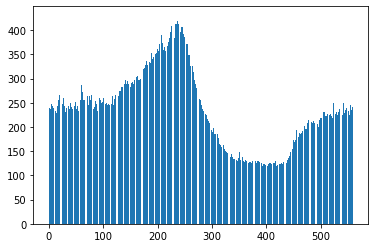

In [13]:
plot.bar(x=range(560), height=PPP1[:560,0])

In [ ]:
# FORTRAN CASE #0
CALL DEVLCG(M,AU,M,EVU)

In [ ]:
A = np.array([[complex(1,2),complex(3,4),complex(21,22)],
              [complex(43,44),complex(13,14),complex(15,16)],
              [complex(5,6),complex(7,8),complex(25,26)]])

ans = DEVLCG(A) # APPLYING DEVLCG* TO "A" MATRIX
# THE PROBLEM IS LAST TWO ITEMS OF THE MATRIX ARE SWAPPED !!!
ans

In [ ]:
# FORTRAN CASE #1
CALL DLFTCG*(M1,A1,M1,A2,M1,IPVT1)
CALL DLFDCG**(M1,A2,M1,IPVT1,DET10,DET20)

In [ ]:
# CHECKING DLFTCG * version 1
A = np.array([[complex(1,1),complex(2,3),complex(3,-3)],
              [complex(2,1),complex(5,3),complex(7,-5)],
              [complex(-2,1),complex(-4,4),complex(5,3)]])
B = np.array([[complex(3,5),complex(9,0)],
              [complex(22,10),complex(13,9)],
              [complex(-10,4),complex(6,10)]])

FAC, IPVT = lu_factor(A) # APPLYING DLFTCG* TO "A" MATRIX

In [ ]:
# CHECKING DLFTCG * version 2
A = np.array([[complex(3,-2), complex(2,4), complex(0,-3)],
              [complex(1,1), complex(2,-6), complex(1,2)],
              [complex(4,0), complex(-5,1), complex(3,-2)]])

p, l, u = lu(A)

In [ ]:
# APPLYING DLFDCG to DLFTCG's factoraziation RESLUT
np.linalg.det(l*u)

In [ ]:
 # APPLYING LFSCG to DLFTCG's factoraziation RESLUT
lu_solve((FAC, IPVT), B)

In [ ]:
# FORTRAN CASE #3
CALL DLFDCG(M1,A2,M1,IPVT1,DET10,DET20)

In [ ]:
np.linalg.det(A)

In [ ]:
C $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$ REPLACER FEATURE $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
      A1(1,1)=CMPLX(1.00000000,2.00000000)
	A1(2,1)=CMPLX(1.00000000,2.00000000)
	A1(3,1)=CMPLX(1.00000000,2.00000000)
	A1(4,1)=CMPLX(1.00000000,2.00000000)
	
      A1(1,2)=CMPLX(2.00000000,3.00000000)
	A1(2,2)=CMPLX(2.00000000,3.00000000)
	A1(3,2)=CMPLX(2.00000000,3.00000000)
	A1(4,2)=CMPLX(2.00000000,3.00000000)

      A1(1,3)=CMPLX(3.00000000,4.00000000)
	A1(2,3)=CMPLX(3.00000000,4.00000000)
	A1(3,3)=CMPLX(3.00000000,4.00000000)
	A1(4,3)=CMPLX(3.00000000,4.00000000)
	
      A1(1,4)=CMPLX(4.00000000,5.00000000)
	A1(2,4)=CMPLX(4.00000000,5.00000000)
	A1(3,4)=CMPLX(4.00000000,5.00000000)
	A1(4,4)=CMPLX(4.00000000,5.00000000)

	DO 1221 I=1,4
	IPVT1(I)=CMPLX(0.00000000,0.00000000)
	DO 1221 J=1,4
	A2(I,J)=CMPLX(0.00000000,0.00000000)
 1221	CONTINUE
C $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$ REPLACER FEATURE $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$


In [ ]:
C @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ DEBUGGING TOOL @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
      PRINT 999,Y
	WRITE(777,999)Y
C @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ DEBUGGING TOOL @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@	      	       	

debug("var", var)

In [ ]:
  999	FORMAT(5X, F16.8)
  998	FORMAT(5X, 5I10)
  991   FORMAT('BLOCK 1 RUNS')
  992   FORMAT('BLOCK 2 RUNS')
  995	FORMAT('CALL RASCHET')
  993   FORMAT(I3,I3,I3)

In [ ]:
A = np.random.randint(-20,20,(4,4))
A = np.array([[3,-13,9,3], [-6,4,1,-18], [6,-2,2,4], [12,-8,6,10]])
A = np.array([[complex(1,1),complex(2,3),complex(3,-3)],
              [complex(2,1),complex(5,3),complex(7,-5)],
              [complex(-2,1),complex(-4,4),complex(5,3)]])
A

In [ ]:
from copy import deepcopy

def custom_lu_factor(A):
    nA = deepcopy(A)
    rows, cols = nA.shape
    if rows == cols:
        square_size = rows
    S = []
    
    for row in nA:
        S.append(max(abs(row)))
#     print("S vector: ", S, "\n")
    
    for ii, iteration in enumerate(reversed(range(2, square_size+1))):
    
        # Finding pivot row 
        ratio_vector = list(abs(nA[ii:,ii])/S[ii:])
#         print("Ratio vector: ",ratio_vector, "\n")
        max_value_index_of_column = ratio_vector.index(max(ratio_vector))

        # Swapping rows
#         print("Before swapping: ")
#         print(nA, "\n")
        nA[[ii, iteration-max_value_index_of_column],:] = nA[[iteration-max_value_index_of_column, ii],:] 
#         print("After swapping: ")
#         print(nA, "\n")

        # Applying Gaussian Reduction
        if square_size == 4:
            if iteration == 4:
                nA[1,:] = nA[1,:] + nA[0,:]
                nA[2,:] = nA[2,:] - nA[0,:]/2
                nA[3,:] = nA[3,:] - 2*nA[0,:]
#                 print("After Gaussian Reduction:")
#                 print(nA, "\n")
            elif iteration == 3:
                nA[2,:] = nA[2,:] + nA[1,:]/6
                nA[3,:] = nA[3,:] - nA[1,:]/3
#                 print("After Gaussian Reduction:")
#                 print(nA, "\n")
            elif iteration == 2:
                nA[3,:] = nA[3,:] + nA[2,:]*2/13
#                 print("After Gaussian Reduction:")
#                 print(nA, "\n")
        if square_size == 3:
            if iteration == 3:
                nA[1,:] = nA[1,:] + nA[0,:]
                nA[2,:] = nA[2,:] - nA[0,:]/2
#                 print("After Gaussian Reduction:")
#                 print(nA, "\n")
            elif iteration == 2:
                nA[2,:] = nA[2,:] + nA[1,:]/6
#                 print("After Gaussian Reduction:")
#                 print(nA, "\n")
    return nA

    

In [ ]:
custom_lu_factor(A)